<h1 style="font-family: Georgia; font-size:3em;color:#2462C0; font-style:bold">
ConvNet: Cats Vs Dogs</h1><br>

In this notebook, we'll explore CNNs implemented on cats-vs-dogs dataset from Kaggle. Due to computational constraints, we'll use only 2000 images for training, 1000 for validation, and 1000 for test. Easy dataset will be divided equally between cats and dogs images.

The notebook will cover:
- Implementing simple CNN
- Implementing simple CNN with data augmentation
- Transfer learning:
    - Feature extraction
    - Feature extraction with data augmentation
    - Fine tune pre-trained CNN
- Visualize activation filters
- Visualize what an activation filter is most responsive for.

In [1]:
import os
import sys

import keras.backend as K
from keras import models, Model, layers, optimizers
from keras.layers import Dense, Dropout, Conv2D, MaxPool2D, Flatten
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.applications import VGG16
from keras.models import load_model
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from tensorflow.python.client import device_lib
import tensorflow as tf
from warnings import filterwarnings

sys.path.append('../utils/')
from copy_cats_and_dogs_images import copy_cats_and_dogs_images
import utils

%matplotlib inline
plt.style.use('fivethirtyeight')
sns.set_context("notebook")
filterwarnings('ignore')

Using TensorFlow backend.


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
device = tf.test.gpu_device_name()
if device != '/device:GPU:0':
    raise SystemError('GPU device not found.')
print(device)

SystemError: GPU device not found.

In [4]:
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 8209451361445308098]

In [5]:
# Copy cats and dogs images from download dir to their respective directories
# Uncomment the code below if you have not copied them
# src = '/Users/imad/Downloads/train/'
# dst = '/Users/imad/Documents/deep_learning_with_keras/data/cats_and_dogs_small/'
# train_dir, valid_dir, test_dir = copy_cats_and_dogs_images(src, dst, 1000, 500, 500)
train_dir = '../data/cats_and_dogs_small/train/'
valid_dir = '../data/cats_and_dogs_small/validation/'
test_dir = '../data/cats_and_dogs_small/test/'

Let's plot an image of each class:

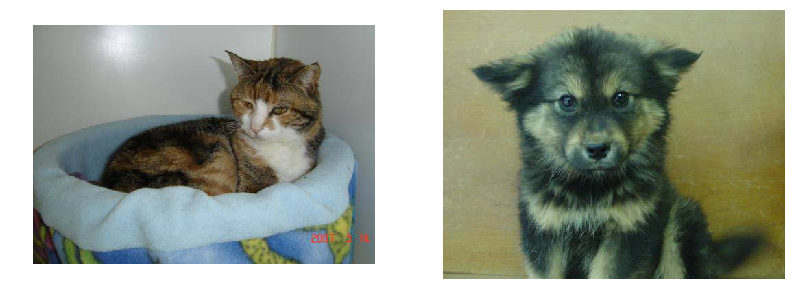

In [6]:
# Plot random cat and dog
cats_fnames = os.listdir(os.path.join(train_dir + '/cats'))
dogs_fnames = os.listdir(os.path.join(train_dir + '/dogs'))
random_cat = os.path.join(train_dir + '/cats', np.random.choice(cats_fnames))
random_dog = os.path.join(train_dir + '/dogs', np.random.choice(dogs_fnames))
cat = plt.imread(random_cat)
dog = plt.imread(random_dog)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 12))
ax1.imshow(cat)
ax2.imshow(dog)
for ax in fig.axes:
    ax.axis('off');

<h2 style="font-family: Georgia; font-size:2em;color:purple; font-style:bold">
Simple CNN</h2><br>

In [7]:
# Build simple CNN
model = models.Sequential([
    Conv2D(32, 3, activation='relu', input_shape=(150, 150, 3)),
    MaxPool2D(2),
    Conv2D(64, 3, activation='relu'),
    MaxPool2D(2),
    Conv2D(128, 3, activation='relu'),
    MaxPool2D(2),
    Conv2D(128, 3, activation='relu'),
    MaxPool2D(2),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(1, activation='sigmoid')
])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 15, 15, 128)       147584    
__________

In [8]:
# Compile the model
model.compile(optimizer=optimizers.rmsprop(lr=1e-4),
              loss='binary_crossentropy',
              metrics=['acc'])

# Prepare ImageDataGenerator class (only rescale images)
train_datagen = ImageDataGenerator(rescale=1/255)
test_datagen = ImageDataGenerator(rescale=1/255)

train_generator = train_datagen.flow_from_directory(directory=train_dir,
                                                    target_size=(150, 150),
                                                    batch_size=20,
                                                    class_mode='binary')

valid_generator = test_datagen.flow_from_directory(directory=valid_dir,
                                                    target_size=(150, 150),
                                                    batch_size=20,
                                                    class_mode='binary')

# Fit the model using data generators
history = model.fit_generator(train_generator,
                              steps_per_epoch=100,
                              epochs=20,
                              validation_data=valid_generator,
                              validation_steps=50)

# Save the model
model.save('../models/cats-vs-dogs-small-no-aug.h5')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/20
100/100 [==============================] - 56s 559ms/step - loss: 0.6881 - acc: 0.5380 - val_loss: 0.6651 - val_acc: 0.6060
Epoch 2/20
100/100 [==============================] - 52s 517ms/step - loss: 0.6475 - acc: 0.6225 - val_loss: 0.6387 - val_acc: 0.6180
Epoch 3/20
100/100 [==============================] - 56s 563ms/step - loss: 0.5997 - acc: 0.6765 - val_loss: 0.6074 - val_acc: 0.6550
Epoch 4/20
100/100 [==============================] - 50s 504ms/step - loss: 0.5620 - acc: 0.7020 - val_loss: 0.5926 - val_acc: 0.6810
Epoch 5/20
100/100 [==============================] - 51s 514ms/step - loss: 0.5325 - acc: 0.7240 - val_loss: 0.5882 - val_acc: 0.6690
Epoch 6/20
100/100 [==============================] - 52s 515ms/step - loss: 0.5062 - acc: 0.7470 - val_loss: 0.5837 - val_acc: 0.6940
Epoch 7/20
100/100 [==============================] - 52s 516ms/step - loss: 0.4814 - acc: 0.7670 - val_lo

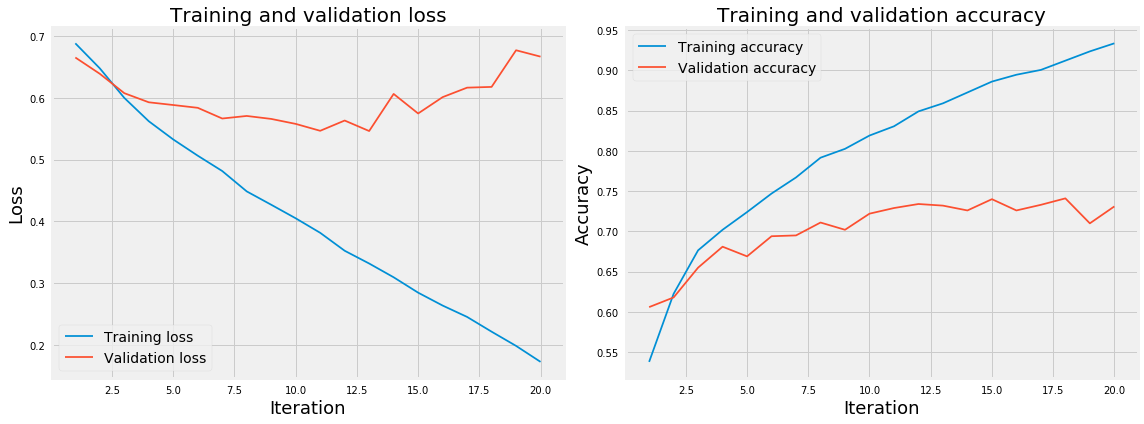

In [9]:
# Plot metrics and loss
utils.plot_loss_and_metric(history, metric_name='acc')

As we can see from the above graphs, validation accuracy has flattened out around 73% after 12 epochs. Our CNN is clearly overfitting with a big gap between validation and training accuracies. This is expected since we don't have enough data and the task we're trying to predict is pretty complex.

<h2 style="font-family: Georgia; font-size:2em;color:purple; font-style:bold">
Simple CNN with Data Augmentation</h2><br>
Since we don't have enough data for such a complex perceptual problem, the CNN overfitted the data. Two of the cheapest ways to reduce overfitting and give a good boost to the validation accuracy are *data augmentation* and *dropout*.
- Data Augmentation: It adds distortions to training images. Since on each epoch, the NN won't see the same images again, it can be seen as adding images by applying random transformations on training images that help NN see different aspects of training data distribution --> Generalizes better. Note that the distorted images are correlated, therefore, it doesn't add totally new information as adding new images.
- Dropout: Force each layer to not depend on specific units and to spread out the weights.

Below is an example that illustrates how the image get random different distortions each time.

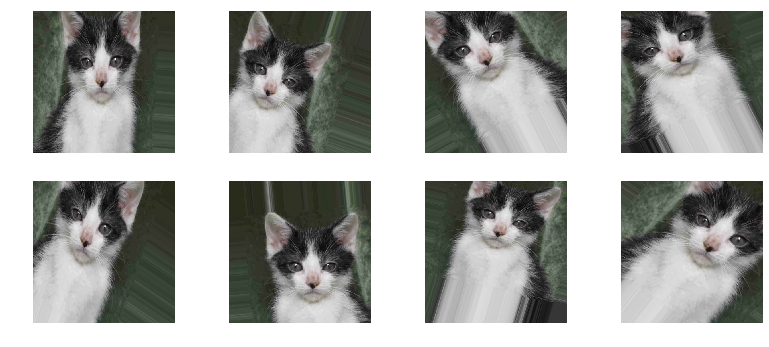

In [10]:
# Illustrate data augmentation on one image
data_gen = ImageDataGenerator(rescale=1/255,
                              rotation_range=40,
                              width_shift_range=0.2,
                              height_shift_range=0.2,
                              shear_range=0.2,
                              horizontal_flip=True,
                              zoom_range=0.2)

img_path = os.path.join(train_dir + '/cats', np.random.choice(cats_fnames))
img = image.load_img(img_path)
img = image.img_to_array(img)
img = img.reshape((1,) + img.shape)

i = 0
plt.figure(figsize=(12, 12))
for batch in data_gen.flow(img, batch_size=1):
    plt.subplot(440 + (i + 1))
    plt.imshow(batch[0])
    plt.axis('off')
    i += 1
    if i == 8:
        break;

In [11]:
# Building small convnet with data augmentation
model = models.Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model.add(MaxPool2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPool2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPool2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPool2D((2, 2)))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 15, 15, 128)       147584    
__________

In [12]:
# Compile model
model.compile(optimizer=optimizers.rmsprop(lr=1e-4),
              loss='binary_crossentropy',
              metrics=['acc'])

# Prepare ImageDataGenerator class
train_datagen = ImageDataGenerator(rescale=1/255,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1/255)

train_generator = train_datagen.flow_from_directory(directory=train_dir,
                                                    target_size=(150, 150),
                                                    batch_size=20,
                                                    class_mode='binary')

valid_generator = test_datagen.flow_from_directory(directory=valid_dir,
                                                    target_size=(150, 150),
                                                    batch_size=20,
                                                    class_mode='binary')

# Fit the model
history = model.fit_generator(train_generator,
                              steps_per_epoch=100,
                              epochs=20,
                              validation_data=valid_generator,
                              validation_steps=50)

# Save the model
model.save('../models/cats-vs-dogs-small-aug.h5')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/20
100/100 [==============================] - 63s 629ms/step - loss: 0.6938 - acc: 0.5110 - val_loss: 0.6853 - val_acc: 0.5000
Epoch 2/20
100/100 [==============================] - 62s 619ms/step - loss: 0.6777 - acc: 0.5755 - val_loss: 0.6574 - val_acc: 0.6080
Epoch 3/20
100/100 [==============================] - 58s 581ms/step - loss: 0.6580 - acc: 0.5990 - val_loss: 0.6323 - val_acc: 0.6260
Epoch 4/20
100/100 [==============================] - 60s 600ms/step - loss: 0.6390 - acc: 0.6155 - val_loss: 0.6158 - val_acc: 0.6570
Epoch 5/20
100/100 [==============================] - 60s 602ms/step - loss: 0.6222 - acc: 0.6465 - val_loss: 0.6175 - val_acc: 0.6500
Epoch 6/20
100/100 [==============================] - 55s 550ms/step - loss: 0.6047 - acc: 0.6685 - val_loss: 0.6244 - val_acc: 0.6440
Epoch 7/20
100/100 [==============================] - 57s 574ms/step - loss: 0.6094 - acc: 0.6640 - val_lo

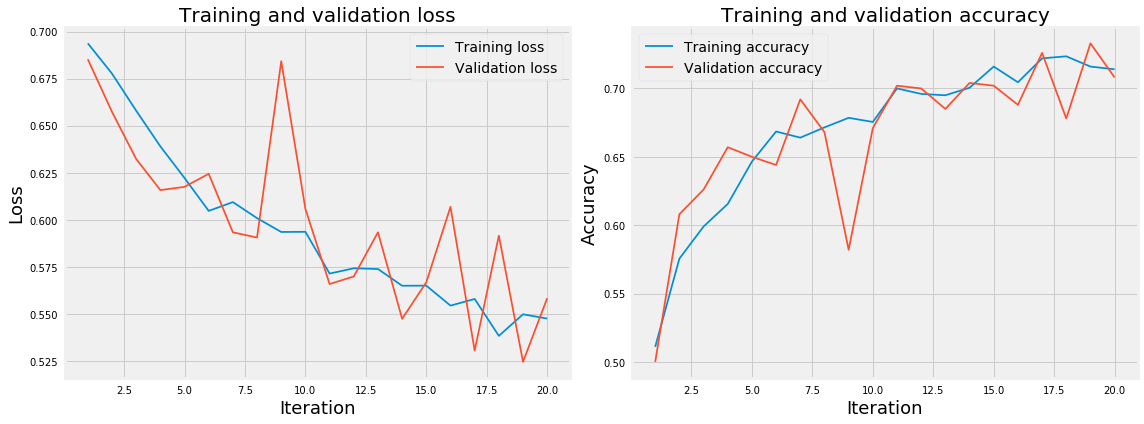

In [13]:
# Plot metrics and loss
utils.plot_loss_and_metric(history, metric_name='acc')

<h2 style="font-family: Georgia; font-size:2em;color:purple; font-style:bold">
Transfer Learning</h2><br>
Transfer learning is very important in deep learning in general especially in computer vision. Most of the times we want to build a CNN that classify images but we won't have enough data to build one with high predictive accuracy. Moreover, CNN are repurposable and can trained over a dataset and used in completely different dataset because:
- The early layers are generic and detect low level features such as edges and contours and are not specific to the task we're solving.
- The later layers start to detect high level features such as objects parts (ears/faces for example).

Therefore, we can use a CNN that was trained on huge datasets such as imagenet and utilize it on solving our own task by using convolutional base and detach the old classifier (last dense layers) with new ones.. Note that the closer our task to the task the pretrained CNN was trained on, the less work we need to do. However, if the task starts to get a bit different, we may need to fine tune and may completely change the higher level layers.

<h3 style="font-family: Georgia; font-size:1.5em;color:purple; font-style:bold">
Feature Extraction</h2><br>
</h3>
With this method, we run all our images through the conv_base of pretrained model all at once and save them on disk. Then we build fully connected NN (classifier) to take the output saved on disk as input and predict the class of each image. It's very fast because on each iteration of training the classifier, we use the output of conv_base saved on disk.

In [14]:
# Build conv model using pretrained model vgg16 without data augmentation
conv_base = VGG16(include_top=False,
                  weights='imagenet',
                  input_shape=(150, 150, 3))
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

In [15]:
# Define feature extraction function to compute the conv_base and store it on disk
batch_size = 20
datagen = ImageDataGenerator(rescale=1/255)

def extract_features(directory, sample_size, conv_base, batch_size=20):
    # Instatiate features and labels
    features = np.zeros((sample_size, 4, 4, 512))
    labels = np.zeros(sample_size)

    # Define generators
    data_gen = ImageDataGenerator(rescale=1/255)
    dir_gen = data_gen.flow_from_directory(directory,
                                           target_size=(150, 150),
                                           batch_size=batch_size,
                                           class_mode='binary')

    # Used to determine when to break the loop
    i = 0
    # Pass images through conv_base to get extracted features
    for images, images_labels in dir_gen:
        features[i * batch_size:(i + 1) * batch_size] = conv_base.predict(images)
        labels[i * batch_size:(i + 1) * batch_size] = images_labels

        i += 1
        if i * batch_size >= sample_size:
            break

    return features, labels

# Get extracted features
train_features, train_labels = extract_features(train_dir, 2000, conv_base, 20)
valid_features, valid_labels = extract_features(valid_dir, 1000, conv_base, 20)
test_features, test_labels = extract_features(test_dir, 1000, conv_base, 20)

# Reshape features
train_features = np.reshape(train_features, (2000, -1))
valid_features = np.reshape(valid_features, (1000, -1))
test_features = np.reshape(test_features, (1000, -1))

# Build the model
model = models.Sequential()
model.add(Dense(256, activation='relu', input_shape=(4 * 4 * 512,)))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer=optimizers.rmsprop(lr=1e-5),
              loss='binary_crossentropy',
              metrics=['acc'])

history = model.fit(train_features,
                    train_labels,
                    epochs=20,
                    batch_size=20,
                    validation_data=[valid_features, valid_labels])

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Train on 2000 samples, validate on 1000 samples
Epoch 1/20
2000/2000 [==============================] - 2s 1ms/step - loss: 0.6910 - acc: 0.6030 - val_loss: 0.5260 - val_acc: 0.7920
Epoch 2/20
2000/2000 [==============================] - 2s 949us/step - loss: 0.5358 - acc: 0.7190 - val_loss: 0.4408 - val_acc: 0.8430
Epoch 3/20
2000/2000 [==============================] - 2s 934us/step - loss: 0.4439 - acc: 0.7985 - val_loss: 0.3910 - val_acc: 0.8570
Epoch 4/20
2000/2000 [==============================] - 2s 905us/step - loss: 0.4017 - acc: 0.8230 - val_loss: 0.3590 - val_acc: 0.8690
Epoch 5/20
2000/2000 [==============================] - 2s 913us/step - loss: 0.3583 - acc: 0.8465 - val_loss: 0.3355 - val_acc: 0.8750
Epoch 6/20
2000/2000 [==============================] - 2s 917us/step - loss: 0.3377 - acc: 0.8585 - val_loss: 0.3242 - val_acc: 0.8750
Epoch 7/20
2

In [16]:
# Save the model
model.save('../models/cats-vs-dogs-small-vgg16-feat-ext-no-aug.h5')

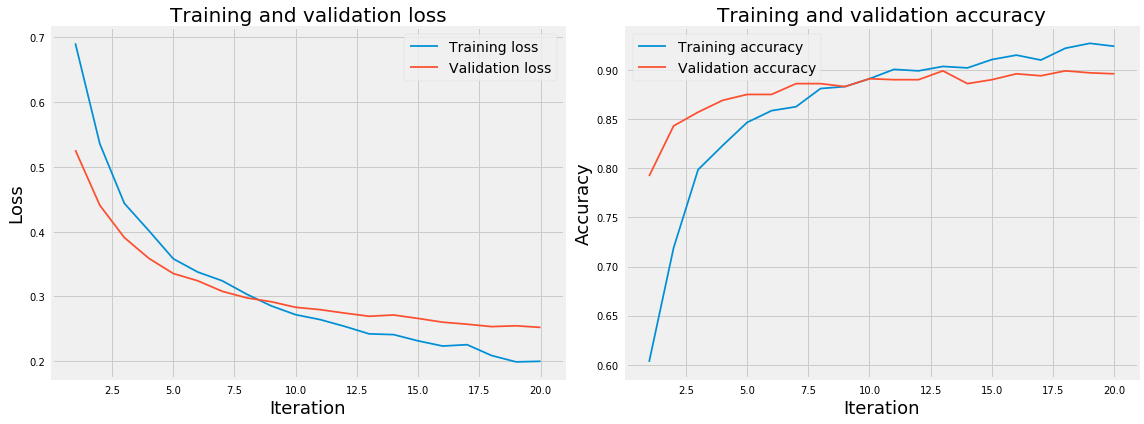

In [17]:
# Plot metrics and loss
utils.plot_loss_and_metric(history, metric_name='acc')

The performance got a lot better. Validation accuracy increased from around 75% to around 90%.

<h3 style="font-family: Georgia; font-size:1.5em;color:purple; font-style:bold">
Feature Extraction with Data Augmentation</h2><br>
</h3>
Saving extracted features on disk prevents us from using data augmentation. Therefore, to use data augmentation, we need to freeze all the layers in the conv_base of the pretrained layers so that we don't change their weights. Then we would train the CNN as usual. This is computationally very expensive compared to the previous method.

In [18]:
# Build conv model using pretrained model vgg16 with data augmentation
model = models.Sequential()
model.add(conv_base)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

# Freeze conv_base trainabel weights
print(f'Number of trainable weights before freezing conv_base weights: '
      f'{len(model.trainable_weights)}')
conv_base.trainable = False
print(f'Number of trainable weights after freezing conv_base weights: '
      f'{len(model.trainable_weights)}')

model.compile(optimizer=optimizers.rmsprop(lr=1e-5),
              loss='binary_crossentropy',
              metrics=['acc'])

# Prepare ImageDataGenerator class
train_datagen = ImageDataGenerator(rescale=1/255,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1/255)

train_generator = train_datagen.flow_from_directory(directory=train_dir,
                                                    target_size=(150, 150),
                                                    batch_size=20,
                                                    class_mode='binary')

valid_generator = test_datagen.flow_from_directory(directory=valid_dir,
                                                    target_size=(150, 150),
                                                    batch_size=20,
                                                    class_mode='binary')

history = model.fit_generator(train_generator,
                              steps_per_epoch=100,
                              epochs=20,
                              validation_data=valid_generator,
                              validation_steps=50)

# Save the model
model.save('../models/cats-vs-dogs-small-vgg16-feat-ext-aug.h5')

Number of trainable weights before freezing conv_base weights: 30
Number of trainable weights after freezing conv_base weights: 4
Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/20
100/100 [==============================] - 217s 2s/step - loss: 0.7548 - acc: 0.5445 - val_loss: 0.5750 - val_acc: 0.7630
Epoch 2/20
100/100 [==============================] - 217s 2s/step - loss: 0.6488 - acc: 0.6240 - val_loss: 0.5018 - val_acc: 0.8220
Epoch 3/20
100/100 [==============================] - 229s 2s/step - loss: 0.5953 - acc: 0.6790 - val_loss: 0.4578 - val_acc: 0.8300
Epoch 4/20
100/100 [==============================] - 239s 2s/step - loss: 0.5546 - acc: 0.7065 - val_loss: 0.4198 - val_acc: 0.8600
Epoch 5/20
100/100 [==============================] - 253s 3s/step - loss: 0.5302 - acc: 0.7340 - val_loss: 0.3921 - val_acc: 0.8700
Epoch 6/20
100/100 [==============================] - 254s 3s/step - loss: 0.4991 - acc: 0.7540 - val_loss: 0.3731 - val_

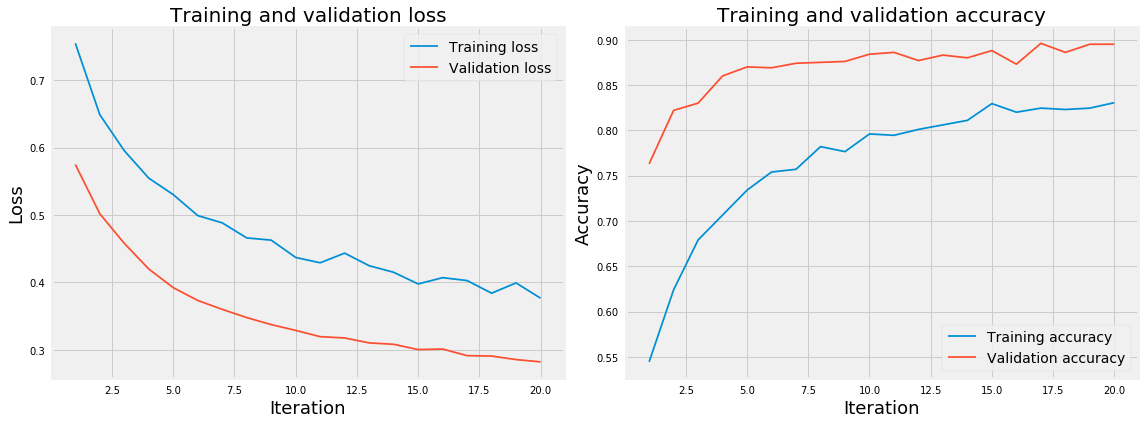

In [19]:
# Plot metrics and loss
utils.plot_loss_and_metric(history, metric_name='acc')

<h3 style="font-family: Georgia; font-size:1.5em;color:purple; font-style:bold">
Fine Tuning</h2><br>
</h3>
Fine tuning is usually done when the task is a little bit different from the task the pretrained CNN was trained on. Depends on how different the tasks are, we may decide to fine tune different number of layers. We usually either don't touch the early layers or use a very low learning rates to update their weights.

Steps of fine tuning:
- Freeze conv_base layers.
- Train the top (classifier) with not high learning rate.
- Unfreeze later layers to be able to train.
- Recompile the model with low learning rate.
- Fit the model again on the same images.

In [20]:
# Unfreeze last block in conv_base
for layer in conv_base.layers:
    if layer.name.startswith('block5'):
        layer.trainable = True

# Recompile the model again to fine tune block5
model.compile(optimizer=optimizers.rmsprop(lr=1e-5),
              loss='binary_crossentropy',
              metrics=['acc'])

history = model.fit_generator(train_generator,
                              steps_per_epoch=100,
                              epochs=20,
                              validation_data=valid_generator,
                              validation_steps=50)

# Save the model
model.save('../models/cats-vs-dogs-samll-vgg16-fine-tune.h5')

Epoch 1/20
100/100 [==============================] - 235s 2s/step - loss: 0.3744 - acc: 0.8285 - val_loss: 0.2800 - val_acc: 0.8920
Epoch 2/20
100/100 [==============================] - 231s 2s/step - loss: 0.3750 - acc: 0.8340 - val_loss: 0.2768 - val_acc: 0.8990
Epoch 3/20
100/100 [==============================] - 214s 2s/step - loss: 0.3790 - acc: 0.8300 - val_loss: 0.2757 - val_acc: 0.8960
Epoch 4/20
100/100 [==============================] - 215s 2s/step - loss: 0.3896 - acc: 0.8255 - val_loss: 0.2735 - val_acc: 0.8980
Epoch 5/20
100/100 [==============================] - 2017s 20s/step - loss: 0.3657 - acc: 0.8480 - val_loss: 0.2710 - val_acc: 0.8960
Epoch 6/20
100/100 [==============================] - 358s 4s/step - loss: 0.3793 - acc: 0.8345 - val_loss: 0.2695 - val_acc: 0.8980
Epoch 7/20
100/100 [==============================] - 211s 2s/step - loss: 0.3612 - acc: 0.8450 - val_loss: 0.2677 - val_acc: 0.8990
Epoch 8/20
100/100 [==============================] - 212s 2s/step 

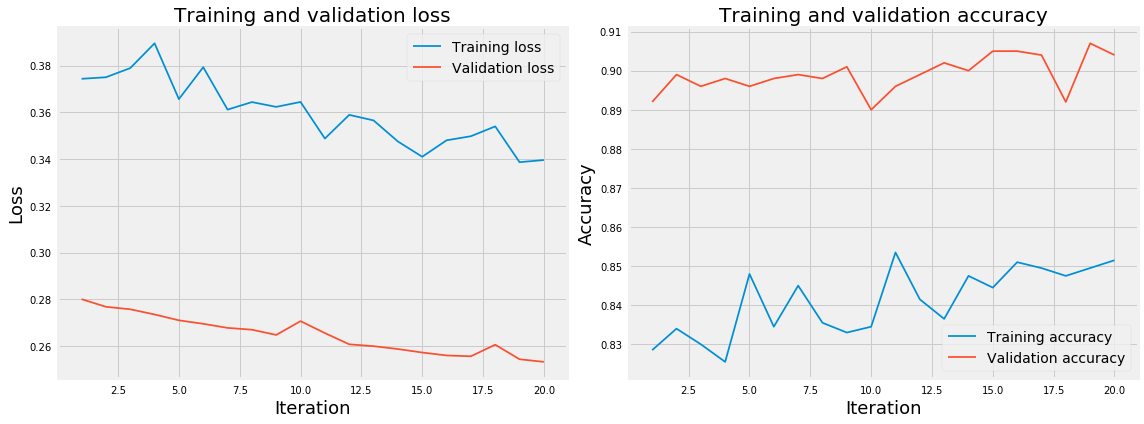

In [21]:
# Plot metrics and loss
utils.plot_loss_and_metric(history, metric_name='acc')

In [22]:
# Compute the weighted average of the loss/accuracy points        
def smooth_curve(points, factor=0.8):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(factor * previous + (1 - factor) * point)
        else:
            smoothed_points.append(point)
            
    return smoothed_points

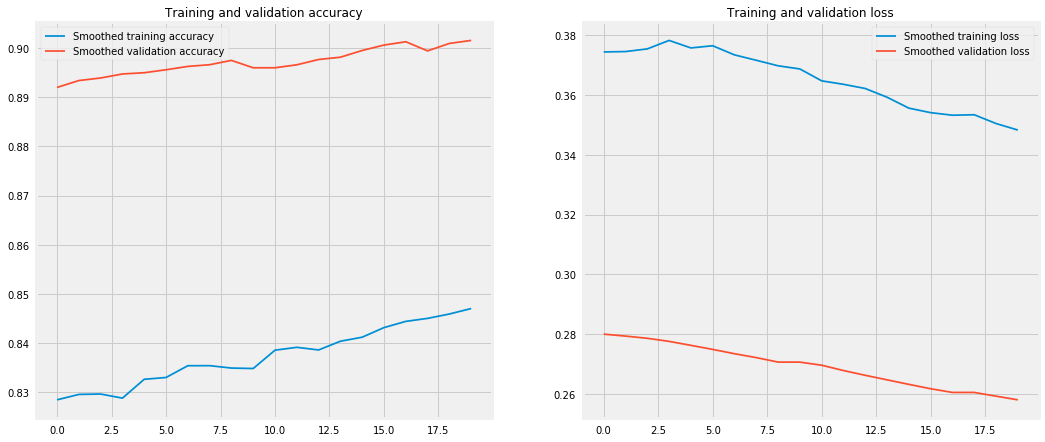

In [23]:
# Plot training and validation accuracy and loss
acc = smooth_curve(history.history['acc'])
loss = smooth_curve(history.history['loss'])
val_acc = smooth_curve(history.history['val_acc'])
val_loss = smooth_curve(history.history['val_loss'])

plt.figure(figsize=(16, 16))
plt.subplot(221)
plt.plot(range(len(acc)), acc, label='Smoothed training accuracy')
plt.plot(range(len(val_acc)), val_acc, label='Smoothed validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.subplot(222)
plt.plot(range(len(loss)), loss, label='Smoothed training loss')
plt.plot(range(len(val_loss)), val_loss, label='Smoothed validation loss')
plt.title('Training and validation loss')
plt.legend()

<h2 style="font-family: Georgia; font-size:2em;color:purple; font-style:bold">
Visualizing Activations</h2><br>

In [25]:
# Load previously trained model
model = load_model('../models/cats-vs-dogs-small-no-aug.h5')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 15, 15, 128)       147584    
__________

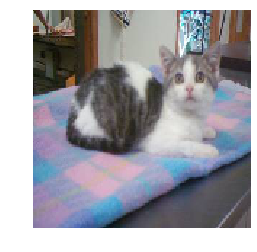

In [27]:
# Pick an image the CNN wasn't trained on, i.e from test images to experiment with
IMG_PATH = '../data/cats_and_dogs_small/test/cats/cat.1529.jpg'
img = image.load_img(IMG_PATH, target_size=(150, 150))
img = image.img_to_array(img)
img = np.reshape(img, ((1,) + img.shape))
img /= 255

# Plot the image
plt.imshow(img[0])
plt.axis('off');

In [28]:
for layer in model.layers:
    print(layer.name)

conv2d_1
max_pooling2d_1
conv2d_2
max_pooling2d_2
conv2d_3
max_pooling2d_3
conv2d_4
max_pooling2d_4
flatten_1
dense_1
dense_2


In [29]:
# Get the output of the conv layers, i.e the first 8 layers in our model
layers_output = [layer.output for layer in model.layers[:8]]

# Build model that takes image as an input and have 8 outputs: One for each conv layer
activation_model = Model(inputs=model.input, outputs=layers_output)

activation_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1_input (InputLayer)  (None, 150, 150, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 17, 17, 128)       0         
__________

In [30]:
# Apply the model on the test image
activations = activation_model.predict(img)

len(activations), activations[0].shape

(8, (1, 148, 148, 32))

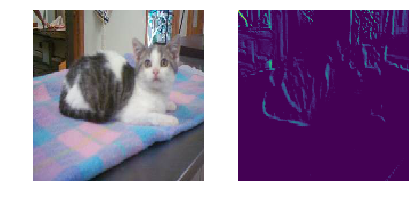

In [31]:
# Plot one filter in the first conv layer
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(img[0])
ax2.imshow(activations[0][0, :, :, 0], cmap='viridis')
ax1.axis('off')
ax2.axis('off');

In [32]:
def plot_conv_outputs(model, img_path, images_per_row=16):
    '''
    Plot output of convolutional layers (activations) in a CNN.
    '''
    # Convert the image into tensor
    img = image.load_img(img_path, target_size=(150, 150))
    img = image.img_to_array(img)
    img = np.reshape(img, ((1,) + img.shape))
    img /= 255

    # Get the the activations
    activations = model.predict(img)

    # These are the names of the layers, so can have them as part of our plot
    layer_names = [layer.name for layer in model.layers[1:]]

    # Now let's display our feature maps
    for layer_name, layer_activation in zip(layer_names, activations):
        # This is the number of features in the feature map
        n_features = layer_activation.shape[-1]

        # The feature map has shape (1, size, size, n_features)
        size = layer_activation.shape[1]

        # We will tile the activation channels in this matrix
        n_cols = n_features // images_per_row
        display_grid = np.zeros((size * n_cols, images_per_row * size))

        # We'll tile each filter into this big horizontal grid
        for col in range(n_cols):
            for row in range(images_per_row):
                channel_image = layer_activation[
                    0, :, :, col * images_per_row + row
                    ]

                # Post-process the feature to make it visually palatable
                channel_image -= channel_image.mean()
                channel_image /= channel_image.std()
                channel_image *= 64
                channel_image += 128
                channel_image = np.clip(channel_image, 0, 255).astype('uint8')
                display_grid[col * size: (col + 1) * size,
                             row * size: (row + 1) * size] = channel_image

        # Display the grid
        scale = 1. / size
        plt.figure(figsize=(scale * display_grid.shape[1],
                            scale * display_grid.shape[0]))
        plt.title(layer_name)
        plt.grid(False)
        plt.imshow(display_grid, aspect='auto', cmap='viridis')

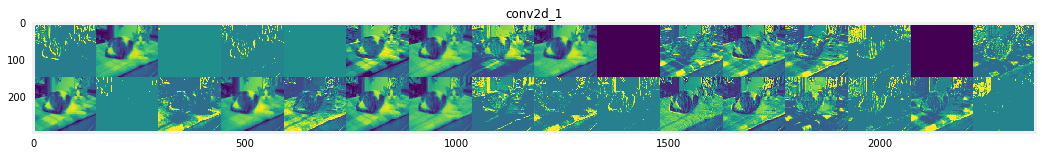

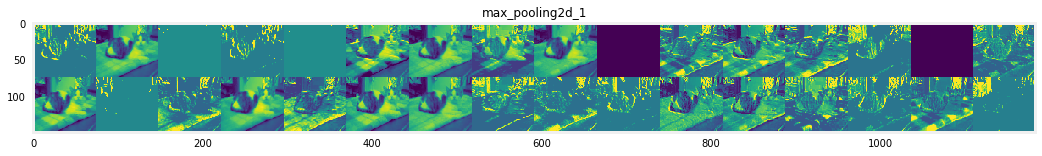

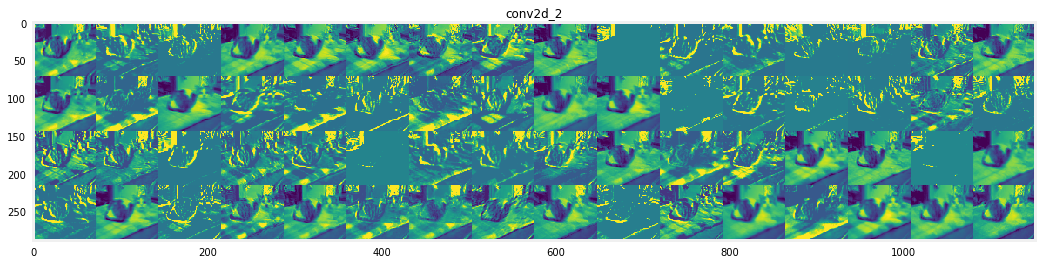

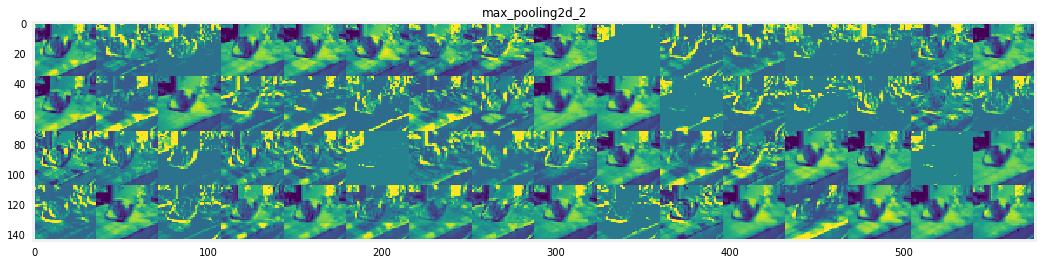

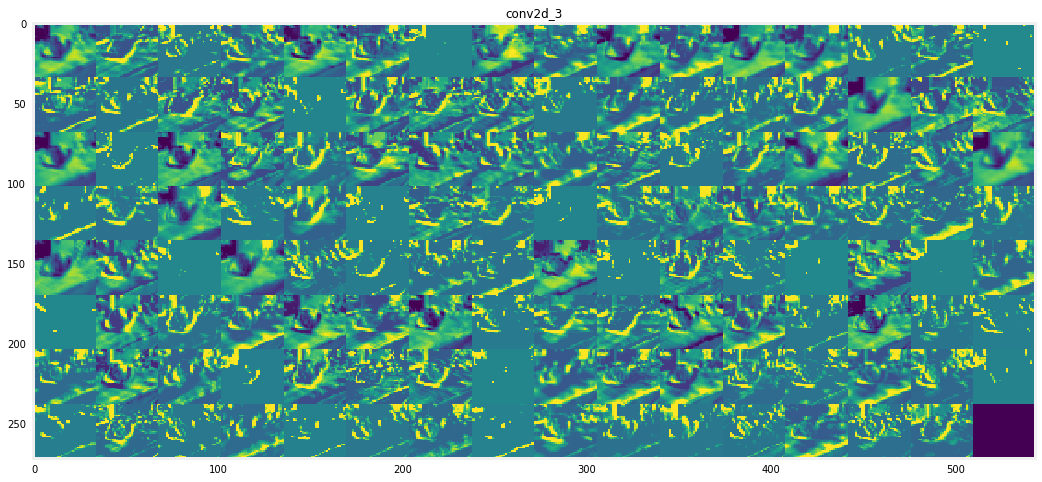

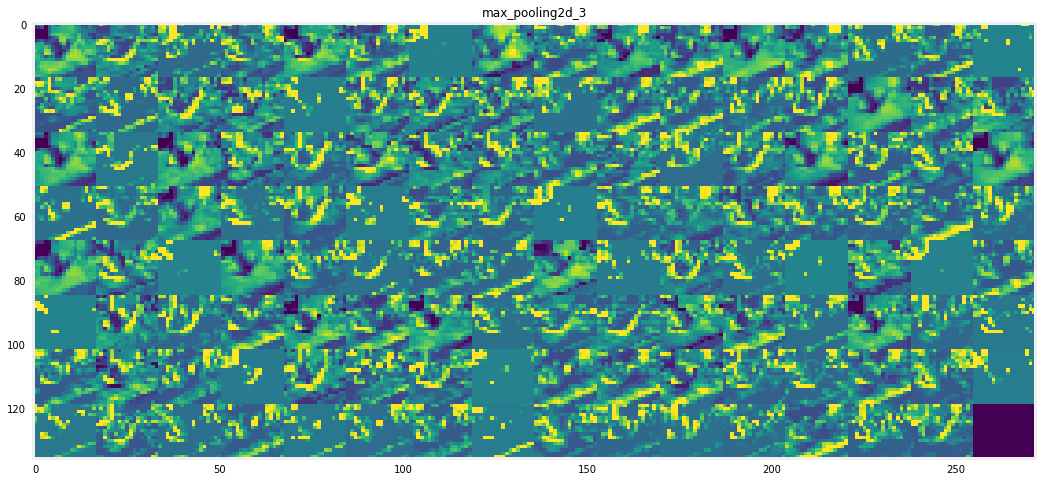

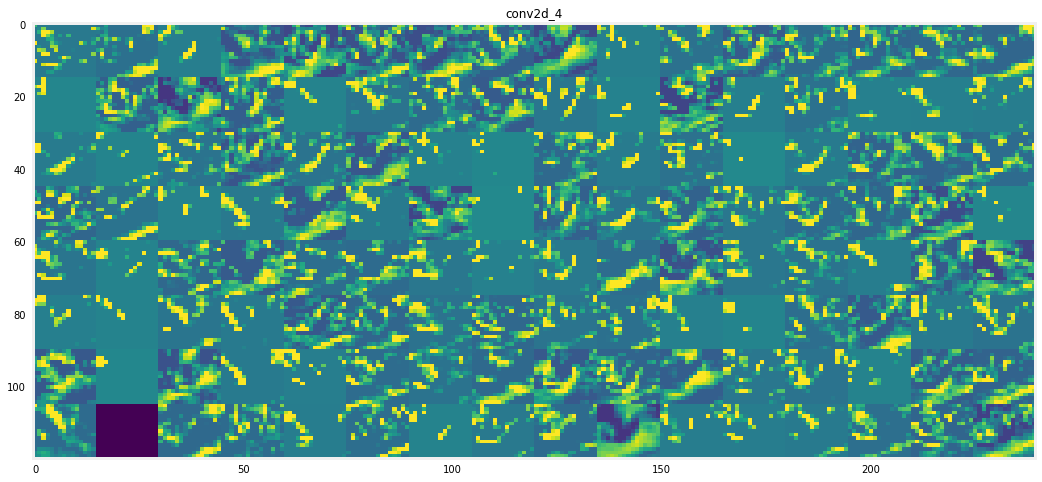

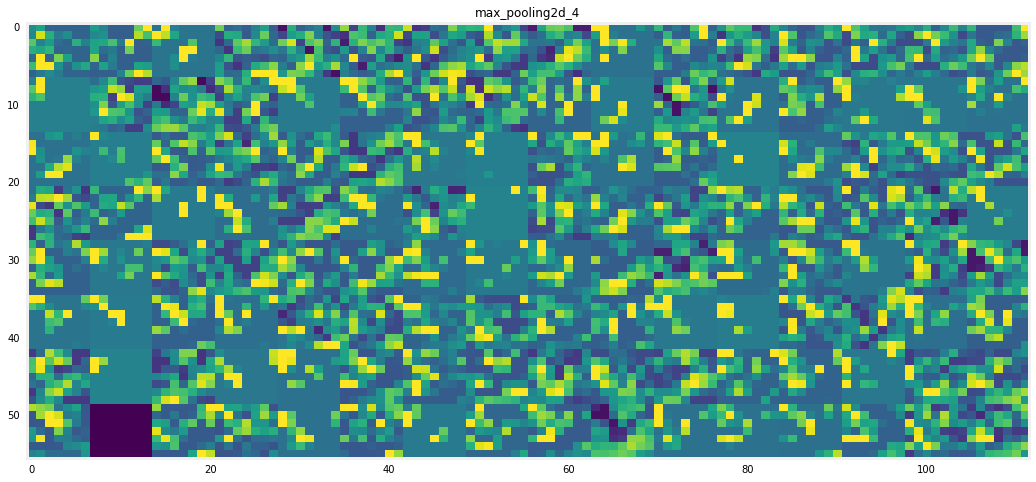

In [33]:
plot_conv_outputs(activation_model, IMG_PATH)

- First layer filters carry most of the information from the image because they detect low level features such as edges.
- As we go to higher layer, filters carry less and less information from the image and more about higher level features such as objects parts (ears of a cat for example).
- Last layers become more sparse because they carry more information about class. Also, some filters are blank because the image may not contain the patterns that those filters responsive for.

<h2 style="font-family: Georgia; font-size:2em;color:purple; font-style:bold">
Visualize conv filters</h2><br>

In [34]:
# Pick a conv layer and a filter in this layer
layer_name = 'block3_conv1'
filter_index = 0

# Use weights from VGG16 model trained on imagenet
model =VGG16(include_top=False, weights='imagenet')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0         
__________

In [35]:
def deprocess_image(x):
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1
    x += 0.5
    x = np.clip(x, 0, 1)
    x *= 255
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [36]:
def generate_patterns(model, layer_name, filter_index=0, iterations=50):
    # Generate random gray image
    random_img = np.random.random((1, 150, 150, 3)) * 20 + 128
    
    # Define output and loss
    output = model.get_layer(layer_name).output
    loss = K.mean(output[:, :, :, filter_index])
    
    # Define gradients
    grads = K.gradients(loss, model.input)[0]
    # Normalize gradients
    grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)
    
    # Define a function that returns loss and gradients w.r.t. input
    compute_loss_grads = K.function([model.input], [loss, grads])
    
    # Start the gradient ascent steps
    lr = 1
    for i in range(iterations):
        loss_value, grads_value = compute_loss_grads([random_img])
        random_img += lr * grads_value
    
    img = random_img[0]
    return deprocess_image(img)

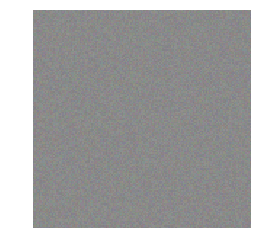

In [37]:
random_img = np.random.random((1, 150, 150, 3)) * 20 + 128
plt.imshow(np.clip(random_img[0], 0, 255).astype('uint8'))
plt.axis('off');

(-0.5, 149.5, 149.5, -0.5)

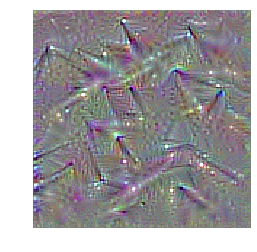

In [38]:
plt.imshow(generate_patterns(model, 'block5_conv2'))
plt.axis('off')

In [174]:
decode_single_preds(model, img)

{'cat': '84.33%', 'dog': '15.67%'}

In [173]:
def decode_single_preds(model, img, class_names=['cat', 'dog']):
    preds = model.predict(img)
    sorted_idx = np.argsort(preds[0])[::-1]
    sorted_preds = preds[0, sorted_idx]
    sorted_class_names = np.array([class_names])[0, sorted_idx]
    res = {}
    
    if preds.shape[1] == 1:
        res[class_names[0]] = f'{1 - preds[0][0]:.2%}'
        res[class_names[1]] = f'{preds[0][0]:.2%}'
    else:
        for i, c in enumerate(sorted_class_names):
            res[c] = f'{sorted_preds[i]:.2%}'
    
    return res